In [0]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.initializers import glorot_uniform as xav

from keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
import networkx as nx
import scipy
!pip install mpld3
import mpld3

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


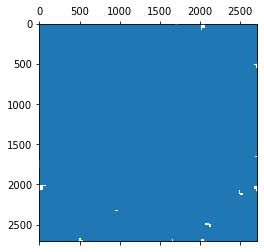

In [0]:
graph = nx.read_weighted_edgelist('/content/gdrive/My Drive/cora.edgelist')
adj = nx.to_scipy_sparse_matrix(graph)
mpld3.enable_notebook()

import scipy.sparse as sparse
plt.spy(adj)

In [0]:
arr11 = scipy.sparse.csr_matrix.toarray(adj)
arr12 = scipy.sparse.csr_matrix.toarray(adj)
arr13 = scipy.sparse.csr_matrix.toarray(adj)

arr2 = scipy.sparse.csr_matrix.toarray(adj)

arr11 = np.reshape(arr11, (arr11.shape[0], arr11.shape[1], 1))
arr12 = np.reshape(arr12, (arr12.shape[0], arr12.shape[1], 1))
arr13 = np.reshape(arr13, (arr13.shape[0], arr13.shape[1], 1))

arr2 = np.reshape(arr2, (arr2.shape[0], arr2.shape[1], 1))

print(arr1.shape)

(2709, 2709, 1)


In [0]:
np.random.shuffle(arr11)
np.random.shuffle(arr12)
np.random.shuffle(arr13)
print(arr1[0].shape)

(2709, 1)


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5*z_log_var) * epsilon

In [0]:
batch_size = 64
input_shape = (arr1.shape[1:])
kernel_size = 3
filters = 1
latent_dim = 2
epochs = 10
use_mse = True
load_weights = False
#train_test_split=0.8
alpha=0.4

In [0]:
xi = Input(shape=input_shape)
xj = Input(shape=input_shape)
xk = Input(shape=input_shape)

encoder_inputs = [xi, xj, xk]
'''for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)'''

# shape info needed to build decoder model
shape = K.int_shape(xi)


# generate latent vector Q(z|X)
xi = Flatten()(xi)
xj = Flatten()(xj)
xk = Flatten()(xk)

fc1 = Dense(512, activation='relu', kernel_initializer = xav(1))
xi = fc1(xi)
xj = fc1(xj)
xk = fc1(xk)

z_mean = Dense(128, name='z_mean', kernel_initializer = xav(1))

z_log_var = Dense(128, name='z_log_var', kernel_initializer = xav(1))

xi_mean = z_mean(xi)
xi_log_var = z_log_var(xi)
xj_mean = z_mean(xj)
xj_log_var = z_log_var(xj)
xk_mean = z_mean(xk)
xk_log_var = z_log_var(xk)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
zi = Lambda(sampling, output_shape=(latent_dim,))([xi_mean, xi_log_var])
zj = Lambda(sampling, output_shape=(latent_dim,))([xj_mean, xj_log_var])
zk = Lambda(sampling, output_shape=(latent_dim,))([xk_mean, xk_log_var])


encoder_output = [zi, xi_mean, xi_log_var, zj, xj_mean, xj_log_var, zk, xk_mean, xk_log_var]

# instantiate encoder model
encoder = Model(encoder_inputs, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
flatten_48 (Flatten)            (None, 2709)         0           input_91[0][0]                   
____________________________________________________________________________________________

In [0]:
zi_input = Input(shape=[128])
zj_input = Input(shape=[128])
zk_input = Input(shape=[128])

# zi_input = tf.expand_dims(zi_input, 0)
# zj_input = tf.expand_dims(zj_input, 0)
# zk_input = tf.expand_dims(zk_input, 0)

latent_input=[zi_input,zj_input,zk_input]

fc1 = Dense(512, activation = 'relu', kernel_initializer = xav(1))
fc2 = Dense(shape[1] * shape[2], activation = 'sigmoid', kernel_initializer = xav(1))
reshape = Reshape((shape[1], shape[2]))

zi_outputs = reshape(fc2(fc1(zi_input)))
zj_outputs = reshape(fc2(fc1(zj_input)))
zk_outputs = reshape(fc2(fc1(zk_input)))

# use Conv2DTranspose to reverse the conv layers from the encoder

'''
l1 = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')

l2 = Conv2DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same')

xi = fc2(zi_input)
xj = fc2(zj_input)
xk = fc2(zk_input)


for i in range(2):
    xi = l1(xi)
    filters //= 2

zi_outputs = l2(xi)

for i in range(2):
    xj = l1(xj)
    filters //= 2

zj_outputs = l2(xj)
    
for i in range(2):
    xk = l1(xk)
    filters //= 2

zk_outputs = l2(xk)

'''

outputs=[zi_outputs,zj_outputs,zk_outputs]


# instantiate decoder model
decoder = Model(latent_input,outputs, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_95 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 512)          66048       input_94[0][0]                   
                                                                 input_95[0][0]             

In [0]:
inputs = encoder_inputs
outputs = decoder([encoder(inputs)[0], encoder(inputs)[3], encoder(inputs)[6]])
vae = Model(inputs, outputs, name='vae')
outputs = tf.concat(values = outputs, axis = 0)

from keras import backend

def func1(x, g_x, size = input_shape[1]):
    funq = K.zeros(x.shape)
    for i in range(size):
        funq = K.add(funq, K.square(K.multiply(x, (x-g_x))))
    
def l2(x, g_x, size = input_shape[1]):
    sum = K.zeros(x.shape) 
    for i in range(size):
        sum = K.add(sum, funq1(x, g_x, size))
    return K.min(sum/K.square(size))

def W2(mean1, var1, mean2, var2):
    return K.square((mean1-mean2)) + K.square((K.sqrt(var1)-K.sqrt(var2)))

def ranking_loss(encoder_outputs):
    _, m1, v1, __, m2, v2, _, m3, v3 = encoder_outputs
    return K.square(W2(m1,v1,m2,v2)) + K.exp(-1*W2(m1,v1,m3,v3))

def vae_loss(x = K.flatten(inputs), x_decoded_mean = K.flatten(outputs)):
    xent_loss = input_shape * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

def kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    if y_true > y_pred:
      return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    return K.sum(y_true * K.log(y_pred / y_true), axis=-1)

def vae_loss(y_true = encoder_inputs, y_pred = outputs):
  w_loss = K.mean(y_true * y_pred)
  return ranking_loss(encoder_output) + alpha*w_loss

#vae.add_loss(losses = kullback_leibler_divergence)
# def loss()

In [0]:
from keras import optimizers
from keras import metrics
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence
from keras.losses import sparse_categorical_crossentropy as scc
from keras.losses import mean_squared_error as mse


adam=optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
rmsprop=optimizers.RMSprop(lr=0.001, rho=0.9)
vae.compile(optimizer=rmsprop, loss=mse, metrics=['acc'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           (None, 2709, 1)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 1 1518848     input_91[0][0]                   
                                                                 input_92[0][0]                 

In [0]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    loss = vae.fit([arr11, arr12, arr13],[arr11, arr12, arr13],epochs=epochs,batch_size=batch_size,validation_split = 0.1)
    vae.save_weights('vae_cnn_mnist.h5')
    vae.summary()

Train on 2438 samples, validate on 271 samples
Epoch 1/10
2438/2438 [==============================] - 1s 613us/step - loss: 0.0656 - decoder_loss: 0.0215 - decoder_acc: 0.9842 - decoder_acc_1: 0.9842 - decoder_acc_2: 0.9842 - val_loss: 0.0049 - val_decoder_loss: 0.0016 - val_decoder_acc: 0.9983 - val_decoder_acc_1: 0.9986 - val_decoder_acc_2: 0.9984
Epoch 2/10
2438/2438 [==============================] - 1s 241us/step - loss: 0.0043 - decoder_loss: 0.0014 - decoder_acc: 0.9986 - decoder_acc_1: 0.9986 - decoder_acc_2: 0.9986 - val_loss: 0.0047 - val_decoder_loss: 0.0015 - val_decoder_acc: 0.9983 - val_decoder_acc_1: 0.9986 - val_decoder_acc_2: 0.9984
Epoch 3/10
2438/2438 [==============================] - 1s 246us/step - loss: 0.0043 - decoder_loss: 0.0014 - decoder_acc: 0.9986 - decoder_acc_1: 0.9986 - decoder_acc_2: 0.9986 - val_loss: 0.0047 - val_decoder_loss: 0.0015 - val_decoder_acc: 0.9983 - val_decoder_acc_1: 0.9986 - val_decoder_acc_2: 0.9984
Epoch 4/10
2438/2438 [=============

In [0]:
# from sklearn.metrics import auc
# a1 = np.concatenate([arr11,arr12,arr13])
# a2 = np.concatenate(vae([tf.convert_to_tensor(arr11),tf.convert_to_tensor(arr12),tf.convert_to_tensor(arr13)]))
# a1 = np.random.shuffle(a1, seed = 1)
# a1 = np.ndarray.flatten(a1)
# a2 = np.random.shuffle(a2, seed = 1)
# a2 = np.ndarray.flatten(a2)
# a1 = tf.convert_to_tensor(a1)
# a2 = tf.convert_to_tensor(a2)
# a1 = tf.cast(a1, float32)

# AUC = auc(a1,a2)